In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from dateutil.parser import parse
import matplotlib.cbook as cbook
import matplotlib.dates as mdates
from sklearn.linear_model import LinearRegression


crime_df = pd.read_csv('rec-crime-pfa.csv')

# Narrative Analytics- Crime in the UK
## Introduction

For this project I'm using a dataset of crime totals in England and Wales 2003-2018 to answer the question: "Did crime increase, decrease, or stay the same after the Brexit announcement on June 23, 2016?" The null hypothesis is that no statistically significant change occurred as a result of Brexit. First, I explored the dataset:

## Exploratory analysis:

In [3]:
print("df dimensions: " + str(crime_df.shape))
print(crime_df.describe())
crime_df.head()

df dimensions: (46469, 5)
       Rolling year total number of offences
count                            46469.00000
mean                              5266.32654
std                              12915.68672
min                               -120.00000
25%                                549.00000
50%                               2011.00000
75%                               5600.00000
max                             308901.00000


,12 months ending,PFA,Region,Offence,Rolling year total number of offences
0,31/03/2003,Avon and Somerset,South West,All other theft offences,25959
1,31/03/2003,Avon and Somerset,South West,Bicycle theft,3090
2,31/03/2003,Avon and Somerset,South West,Criminal damage and arson,26202
3,31/03/2003,Avon and Somerset,South West,Death or serious injury caused by illegal driving,2
4,31/03/2003,Avon and Somerset,South West,Domestic burglary,14561


## Cleaning the data

I noticed a few things during the exploratory analysis:

1) The data is annual until April 2007, then quarterly thereafter. <br>
2) The Offences 'Domestic burglary', 'Non-domestic burglary', 'Residential burglary', and 'Non-residential burglary' are intermixed, causing unclear or invalid results, for example a negative number of crimes committed. <br>
3) The 'PFA' column includes several non-regional jurisdictions: 'Action Fraud', 'CIFAS', and 'UK Finance'. These categories also change over time, which would skew the dataset if included. <br>
4) The Offence 'Fraud Offences' stopped in 31/12/2013, and should be dropped



In [4]:
#rename columns
crime_df.columns = ['Date', 'PFA', 'Region', 'Offence', 'Total']

#convert date column to datetime format
crime_df['Date'] = crime_df['Date'].apply(lambda x: datetime.strptime(x, '%d/%m/%Y'))    
    
#drop non-geographic PFA's, all appear 30/06/2011
for PFA in ['Action Fraud', 'CIFAS', 'UK Finance']:
    crime_df = crime_df[crime_df.PFA != PFA]

#drop Fraud Offences', they stopped recording this in 31/12/2013
crime_df = crime_df[crime_df.Offence != 'Fraud offences']

#drop [non]domestic/residential burglaries
for offence in ['Domestic burglary', 'Non-domestic burglary',
                'Residential burglary', 'Non-residential burglary']:
    crime_df = crime_df[crime_df.Offence != offence]

#drop all pre-April 2007 data, so all data is quarterly
for year in ['31/03/2003', '31/03/2004', '31/03/2005', '31/03/2006', '31/03/2007']:
    crime_df = crime_df[crime_df.Date != year]
    

# Create 'experimental' and 'control' groups

I will split the data in pre- and post-brexit groups. This will allow me to compare crime rates before and after the referendum, and also use the pre-Brexit dataset as a 'control' training set to predict post-Brexit crime, using the post Brexit dates as my target. I'll then group by the 17 different offences to create a data frame that gives the total number of each crime committed per quarter. 

In [5]:
#bisect into pre- and post-brexit df's
crime_df1 = crime_df.loc[crime_df.Date < datetime(2016, 6, 30)].copy()
crime_df2 = crime_df.loc[crime_df.Date >= datetime(2016, 6, 30)].copy()

#group by total crime by offence per quarter
pre_brexit = crime_df1.groupby(['Date', 'Offence'], as_index=False)['Total'].sum()
post_brexit = crime_df2.groupby(['Date', 'Offence'], as_index=False)['Total'].sum()
complete_df = crime_df.groupby(['Date', 'Offence'], as_index=False)['Total'].sum()


## Plot the data to visualize trends
Before performing analysis, I'll plot the data to get an idea of the trends in crime in the UK from 2007 - 2018.

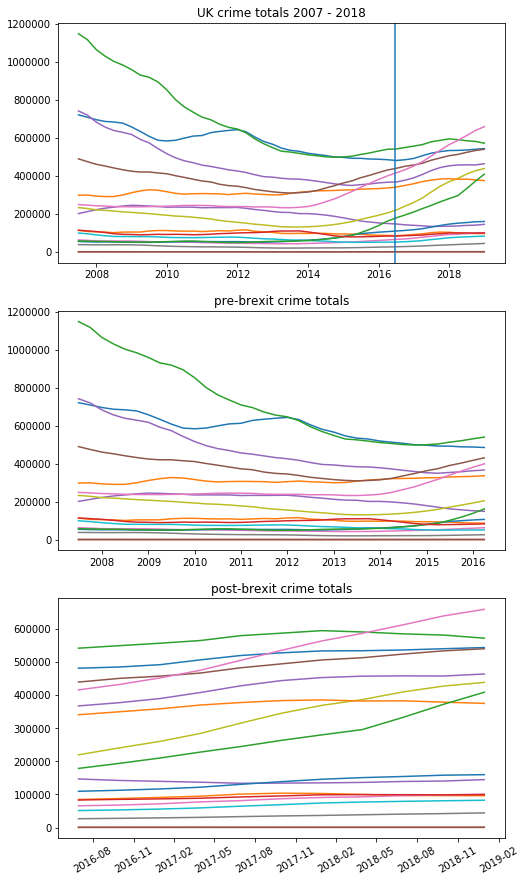

In [6]:
plt.figure(figsize=(8, 15))
plt.subplots_adjust(hspace=0.2)

plt.subplot(3, 1, 1)
plt.title('UK crime totals 2007 - 2018')
for offence in complete_df['Offence'].unique():
    temp = complete_df[complete_df['Offence'] == offence]
    plt.plot(temp['Date'], temp['Total'])
plt.axvline(x=datetime(2016, 6, 23))

plt.subplot(3, 1, 2)
plt.title('pre-brexit crime totals')
for offence in pre_brexit['Offence'].unique():
    temp = pre_brexit[pre_brexit['Offence'] == offence]
    plt.plot(temp['Date'], temp['Total'])

plt.subplot(3, 1, 3)
plt.title('post-brexit crime totals')
for offence in post_brexit['Offence'].unique():
    temp = post_brexit[post_brexit['Offence'] == offence]
    plt.plot(temp['Date'], temp['Total'])
plt.xticks(rotation=30)
    
plt.show()

Next I grouped the 17 different offences in 5 categories to reduce the total number of linear regressions to perform:
1) Violent Crime- Homicide, Robbery, Violence with and without injury
2) Theft Offences- Bicycle Theft, Shoplifting, Theft from the person, and Other Thefts
3) Vehicle Offenses- Death or injury from illegal driving, and Vehicle offence
4) Harassment Offences- Sexual Offence, and Stalking and Harassment
5) Other Offences- Criminal damage & arson, Drug Offences, Weapon possession, Public disorder, and Miscellaneous crimes

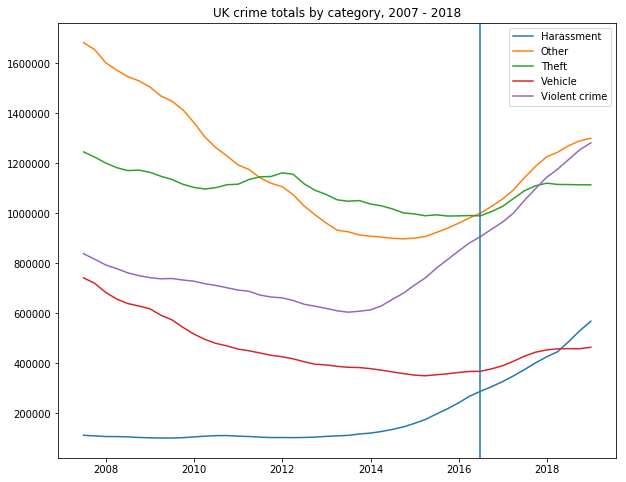

In [7]:
def categorize_crime(row):
    if row['Offence'] in ['Homicide', 'Robbery', 'Violence with injury', 'Violence without injury']:
        return 'Violent crime'
    elif row['Offence'] in ['All other theft offences', 'Bicycle theft', 'Shoplifting', 'Theft from the person']:
        return 'Theft'
    elif row['Offence'] in ['Death or serious injury caused by illegal driving', 'Vehicle offences']:
        return 'Vehicle'
    elif row['Offence'] in ['Sexual offences', 'Stalking and harassment']:
        return 'Harassment'
    elif row['Offence'] in ['Criminal damage and arson', 'Drug offences', 'Miscellaneous crimes against society', 'Public order offences', 'Possession of weapons offences']:
        return 'Other'


complete_df['Crime category'] = complete_df.apply (lambda row: categorize_crime(row), axis=1).copy()
categorized_df = complete_df.groupby(['Date', 'Crime category'], as_index=False)['Total'].sum()

pre_brexit['Crime category'] = pre_brexit.apply (lambda row: categorize_crime(row), axis=1).copy()
pre_categorized_df = pre_brexit.groupby(['Date', 'Crime category'], as_index=False)['Total'].sum()
    
plt.figure(figsize=(10, 8))
plt.title('UK crime totals by category, 2007 - 2018')
for category in categorized_df['Crime category'].unique():
    temp = categorized_df[categorized_df['Crime category'] == category]
    plt.plot(temp['Date'], temp['Total'])
plt.axvline(x=datetime(2016, 6, 23))
plt.legend(categorized_df['Crime category'].unique(), loc='upper right')
plt.show()
    


To compare the trajectory of crime before and after the Brexit referendum, I'll perform a 2 linear regressions on each criminal category with respect to time: one pre-Brexit, and one that includes crime data up to the present day. The 'pre-Brexit' model will show what should have been expected to happen given the trajectory of crime, and the complete model will show the actual trend. 

Difference in pre/post Brexit Violent crime coefficient: 10043.12
Difference in pre/post Brexit Theft coefficient: 3294.409
Difference in pre/post Brexit Harassment coefficient: 5284.032
Difference in pre/post Brexit Vehicle coefficient: 4942.013
Difference in pre/post Brexit Other coefficient: 13282.71


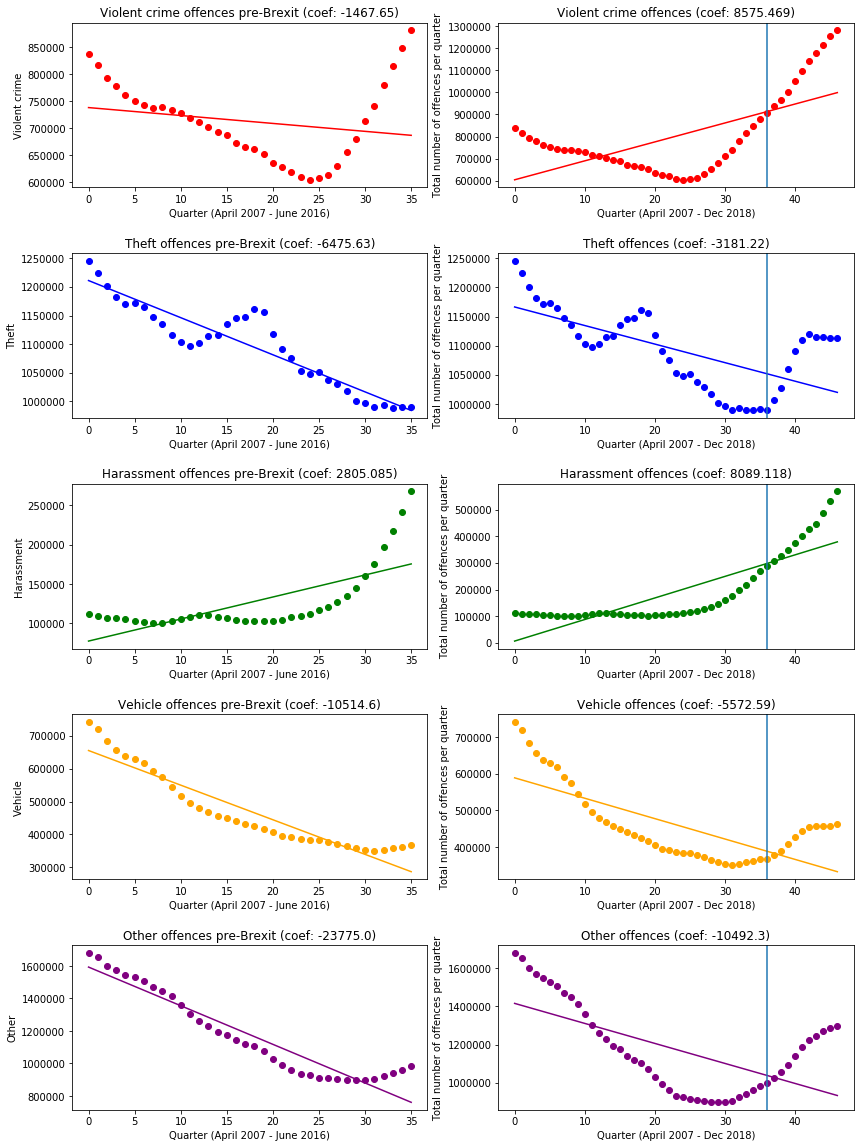

In [15]:
from sklearn import linear_model

plt.figure(figsize=(14,20))

def regress_and_plot(category, plot_color, plot_num):
    plt.subplots_adjust(hspace=0.4)
    
    #plot pre-brexit crime data
    Xy = pre_categorized_df[pre_categorized_df['Crime category'].isin([category, 'Total'])].copy()
    y = Xy[['Total']]
    X = np.array(range(len(Xy))).reshape(-1,1)
    plt.subplot(5,2,plot_num)
    plt.scatter(X, y, color = plot_color)
    model = LinearRegression().fit(X, y)
    r_sq = model.score(X,y)
    pre_slope = model.coef_
    trendline = model.coef_[0] * X + model.intercept_
    plt.plot(X, trendline, color=plot_color)
    plt.title(category + " offences pre-Brexit (coef: " + str(pre_slope)[2:10] + ')')
    plt.xlabel("Quarter (April 2007 - June 2016)")
    plt.ylabel(category)
    
    #plot with post-brexit data
    Xy = categorized_df[categorized_df['Crime category'].isin([category, 'Total'])].copy()
    y = Xy[['Total']]
    X = np.array(range(len(Xy))).reshape(-1,1)
    plt.subplot(5,2,plot_num + 1)
    plt.scatter(X, y, color = plot_color)
    model = LinearRegression().fit(X, y)
    r_sq = model.score(X,y)
    slope = model.coef_
    trendline = model.coef_[0] * X + model.intercept_
    plt.plot(X, trendline, color=plot_color)
    plt.title(category + " offences (coef: " + str(slope)[2:10] + ')')
    plt.xlabel("Quarter (April 2007 - Dec 2018)")
    plt.ylabel("Total number of offences per quarter")
    plt.axvline(x=36)

    print("Difference in pre/post Brexit " + category + " coefficient: " + str(slope - pre_slope)[2:10])
    
regress_and_plot('Violent crime', 'red', 1)
regress_and_plot('Theft', 'blue', 3)
regress_and_plot('Harassment', 'green', 5)
regress_and_plot('Vehicle', 'orange', 7)
regress_and_plot('Other', 'purple', 9)


In every case, the rate of crime increased when I included post-Brexit data. However, in most cases the trend seemed to change in the year before the referendum. The exception is Theft, which seemed to spike in the same quarter as the Brexit referendum. 